### Code to remove diurnal cycle from the wind lidar data and save the resulting data in a ncdf file
##### author: Claudia Acquistapace
##### what the code does for every variable: 
1) reads the original file for each day for the case study of the 2-3 feb 2020 for each variable <br> 
2) applies the function f_clean_lidar_signal_from_noise to remove noise (method based on threshold+cloud base) <br> 
3) reads the diurnal cycle file for each variable <br> 
4) resamples diurnal cycle on time res of original file <br> 
3) subtracts the diurnal cycle file from each daily file <br> 
5) stores the result of the subtraction and the original variable with noise removed in a ncdf file <br> 
##### goal: obtain in ncdf the arthus variables without noise and with diurnal cycle filtered out 
##### date: 24 Nov 2021

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'

dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}


# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

# variable list
var_list =['Hwind_speed_dict','Hwind_dir_dict']

Hwind_speed_dict = {
     'var_name'  : 'V',
     'var_string': 'Horizontal wind speed',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 20.,
     'thr_min'   : 0.,
     'thr_max'   : 20.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'H wind speed: 02/02-02/03'}

Hwind_dir_dict = {
     'var_name'  : 'V',
     'var_string': 'Horizontal wind direction',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 360.,
     'thr_min'   : 0.,
     'thr_max'   : 360.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'H wind dir: 02/02-02/03'}

In [6]:
# setting time window to be checked
string_out = '20200202_20200203'
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)


# read wind lidar data
path_wind_lidar = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_wind_lidar/"
wind_lidar_file = "wind_lidar_eurec4a.nc"
path_fig = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/\
SST_impact_work/plots/"
wind_lidar = xr.open_dataset(path_wind_lidar+wind_lidar_file)

# selecting time interval to extract from wind lidar dataset
w_wind_DS = wind_lidar.sel(time=slice(t_start, t_end))





# reading horizontal wind and speed data
path_Doppler_lidar = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/doppler_lidar/case_1/'
file_1_speed = '20200202_DL_Wind_Speed.nc'
speed_data_1 = xr.open_dataset(path_Doppler_lidar+file_1_speed)
file_2_speed = '20200203_DL_Wind_Speed.nc'
speed_data_2 = xr.open_dataset(path_Doppler_lidar+file_2_speed)


file_1_dir = '20200202_DL_Wind_Direction.nc'
dir_data_1 = xr.open_dataset(path_Doppler_lidar+file_1_dir)

file_2_dir = '20200203_DL_Wind_Direction.nc'
dir_data_2 = xr.open_dataset(path_Doppler_lidar+file_2_dir)

speed_data = xr.merge([speed_data_1, speed_data_2])
dir_data = xr.merge([dir_data_1, dir_data_2])
H_wind_DS = xr.merge([speed_data, dir_data])

# renaming time and height in homogeneous way
H_wind_DS = H_wind_DS.rename_dims({'Time':'time'})
H_wind_DS = H_wind_DS.rename_dims({'Height':'height'})
H_wind_DS = H_wind_DS.rename({'Time':'time'})
H_wind_DS = H_wind_DS.rename({'Height':'height'})

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [4]:
H_wind_DS

<xarray.Dataset>
Dimensions:                    (height: 236, time: 1782)
Coordinates:
  * time                       (time) datetime64[ns] 2020-02-02T00:01:02.2828...
  * height                     (height) float32 15.0 45.0 75.0 ... 7035.0 7065.0
Data variables:
    Range_Resolution           float32 30.0
    Horizontal_Wind_Speed      (time, height) float32 0.49769747 ... 6.213207
    Horizontal_Wind_Direction  (time, height) float32 255.15195 ... 120.06517

In [9]:
 # set to nan the values out of the thresholds for the selected variable for horizontal wind speed 
mask = (H_wind_DS["Horizontal_Wind_Speed"].values > Hwind_speed_dict['thr_min']) & (H_wind_DS["Horizontal_Wind_Speed"].values < Hwind_speed_dict['thr_max'])
H_wind_DS["nans"] = xr.full_like(H_wind_DS['Horizontal_Wind_Speed'], fill_value=np.nan)
H_wind_DS['Horizontal_Wind_Speed'] = xr.where(mask, H_wind_DS['Horizontal_Wind_Speed'], H_wind_DS["nans"])

# set to nan the values out of the thresholds for the selected variable for horizontal wind direction 
mask = (H_wind_DS["Horizontal_Wind_Direction"].values > Hwind_dir_dict['thr_min']) & (H_wind_DS["Horizontal_Wind_Direction"].values < Hwind_dir_dict['thr_max'])
H_wind_DS["nans"] = xr.full_like(H_wind_DS['Horizontal_Wind_Direction'], fill_value=np.nan)
H_wind_DS['Horizontal_Wind_Direction'] = xr.where(mask, H_wind_DS['Horizontal_Wind_Direction'], H_wind_DS["nans"])



In [17]:
# opening noise mask file to read cloud base
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
cloud_base = noise_mask.cloud_base_height.values

# restricting noise mask data to the day that is read
noise_mask = noise_mask.sel(Time=slice(H_wind_DS['time'].values[0],H_wind_DS['time'].values[-1]))

# interpolating time of the arthus product (T,WVMR, LHF, SHF) on the time of the noise mask (BR ratio time res)
H_wind_DS_interp = H_wind_DS.interp(time=noise_mask['Time'].values)

# find closest height of arthus data to the threshold height for every time stamp
arthus_height_thr = []
for ind_t in range(len(H_wind_DS_interp.time.values)):
    arthus_height_thr.append(H_wind_DS_interp['height'].values[f_closest(H_wind_DS_interp['height'].values, cloud_base[ind_t])])    

# building noise mask for arthus_data
mask = np.ones((len(pd.to_datetime(H_wind_DS_interp['time'].values)),len(H_wind_DS_interp['height'].values)))
for ind in range(len(pd.to_datetime(H_wind_DS_interp['time'].values))):    
    ind_zero = np.where(H_wind_DS_interp['height'].values > arthus_height_thr[ind])
    mask[ind,ind_zero[0]] = 0.
    

# applying the mask to the product variable
H_wind_DS_interp["nans"] = xr.full_like(H_wind_DS_interp.Horizontal_Wind_Speed, fill_value=np.nan)
H_wind_DS_interp['Horizontal_Wind_Speed'] = xr.where(mask, H_wind_DS_interp['Horizontal_Wind_Speed'], H_wind_DS_interp["nans"])
H_wind_DS_interp['Horizontal_Wind_Direction'] = xr.where(mask, H_wind_DS_interp['Horizontal_Wind_Direction'], H_wind_DS_interp["nans"])


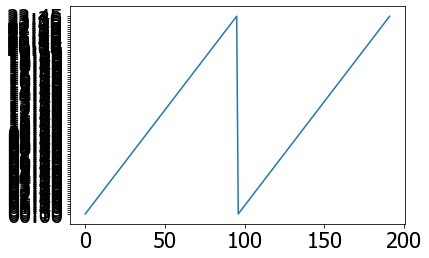

In [23]:
plt.plot(H_wind_DS_interp['time'])

In [22]:
# calculate diurnal cycle for horizontal wind speed and direction
# calculating the mean of the variable over the time interval requested
H_wind_DS_interp = H_wind_DS_interp.resample(time=Hwind_speed_dict['avg_time']+'T').mean()

# re-writing time array as hh:mm for then being able to group
H_wind_DS_interp['time'] = pd.to_datetime(H_wind_DS_interp.time.values).strftime("%H:%M")

# grouping and calculating mean of the profiles
grouped_mean = H_wind_DS_interp.groupby('time').mean()
grouped_std = H_wind_DS_interp.groupby('time').std()

ValueError: index must be monotonic for resampling

In [14]:







# saving diurnal cycle in ncdf file
dims             = ['Time','Height']
coords           = {"Time":pd.to_datetime(grouped_mean['time'].values), "Height":grouped_mean['height'].values}
diurnal_cycle       = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['Horizontal'].values,\
                     attrs={'long_name':'diurnal cycle over '+dict_var['avg_time']+'min for '+dict_var['var_string'],\
                            'units':dict_var['var_units']})
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'diurnal cycle of the variable '+dict_var['var_string']+'calculated over '+dict_var['avg_time']+'minutes',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'arthus data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                     'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset    = xr.Dataset(data_vars = {'diurnal_cycle':diurnal_cycle},
                                  coords = coords,
                                   attrs = global_attributes)
dataset.to_netcdf(path_out+dict_var['var_name']+'_diurnal_cycle.nc')

<xarray.Dataset>
Dimensions:            (Height: 375, Time: 16592)
Coordinates:
  * Time               (Time) datetime64[ns] 2020-02-02T00:01:09 ... 2020-02-...
  * Height             (Height) float32 198.75 206.25 213.75 ... 2996.25 3003.75
Data variables:
    noise_mask         (Time, Height) float64 ...
    cloud_base_height  (Time) float32 2078.75 2056.25 2056.25 ... 503.75 151.25
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2021-11-22 16:57:34.061340
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DO_NAME:           University of Cologne - Germany
    DO_AFFILIATION:    University of Cologne - Germany
    DO_address:        Institute for geophysics and meteorology, Pohligstrass...
    DO_MAIL:           cacquist@meteo.uni-koeln.de
    DS_NAME:           University of Cologne - Germany
    DS_AFFILIATION:    University of Cologne - Germany
    DS_address:        Institute for geophysics and meteorology, Pohligstrass...
    DS_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  hourly MRR correction terms on Maria S. Merian ship du...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Radar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           data postprocessed by Diego Lange

In [18]:
# read diurnal cycle file
    d_cycle = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'_diurnal_cycle.nc')

    # calculate new time array for diurnal cycle
    time_start = datetime(2020,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].day,0,0,0)
    time_end = datetime(2020,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].day,23,59,59)

    new_time = np.arange(time_start, time_end, timedelta(minutes=int(dict_var['avg_time']))).astype(datetime)
    d_cycle['Time'] = new_time


    # resampling diurnal cycle on arthus time 
    #arthus_data = arthus_data.interp(Time=d_cycle['Time'].values)
    d_cycle_arthus = d_cycle.interp(Time=arthus_no_noise['Time'].values, method='nearest')

    # subtracting diurnal cycle from arthus variable
    var_no_dc = arthus_no_noise['Product'].values - d_cycle_arthus['diurnal_cycle'].values
    
    









